### Sanity checks on the topic modelling project for DM dataset


Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 10/06/2024\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



In [5]:
%%capture
# !pip install bertopic accelerate bitsandbytes xformers adjustText
# !pip install llama-cpp-python
# !{sys.executable} -m pip install "scipy==1.9.0" "scikit-image==0.23.2"

import os
import nltk
import sys
import pandas as pd

from grid_search_colyra import *
from META_helpers_colyra import split_sentences, reduced_custom_stopwords


os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')

condition = "HS"
condition2 = "DL"
sentences = True
random_seed = 22
nr_topics = None 

results_GS = pd.read_csv(f'/home/romy/lyra/RESULTSentences/grid_search_results_{condition}_seed22.csv')

reports_path = os.path.join("DATA2",f"{condition}_reflections.csv")
df_reports = pd.read_csv(reports_path,sep="\t")['reflection_answer']


if sentences:
    df_reports = split_sentences(df_reports)

results_GS.head(5)



### Condition 2 : the one we want to compare to list topics from reference condition (condition 1) ###

results_GS2 = pd.read_csv(f'/home/romy/lyra/RESULTSentences/grid_search_results_{condition2}_seed22.csv')

reports_path2 = os.path.join("DATA2",f"{condition2}_reflections.csv")
df_reports2 = pd.read_csv(reports_path2,sep="\t")['reflection_answer']


if sentences:
    df_reports2 = split_sentences(df_reports2)


results_GS = results_GS[results_GS['cohenrece_score_umass'].notnull()]

results_GS.head(5)




In [6]:
chosen_params = results_GS.iloc[0]
chosen_params

n_components                                                             9
n_neighbors                                                             10
min_dist                                                               0.0
min_cluster_size                                                        10
min_samples                                                              6
coherence_score                                                   0.562414
cohenrece_score_umass                                            -8.175496
n_topics                                                                17
model                    BERTopic(calculate_probabilities=True, ctfidf_...
Name: 2, dtype: object

In [7]:
sentence_transformer_model = "all-mpnet-base-v2" #"paraphrase-MiniLM-L6-v2"# #"BAAI/bge-small-en" "all-MiniLM-L6-v2'"
embedding_model = SentenceTransformer(sentence_transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)
print(embedding_model)

vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words=list(stopwords.words('english')))#+list(reduced_custom_stopwords)) #ngram_range=(1,2) : unigrams and bigrams

n_neighbors = chosen_params['n_neighbors']
n_components = chosen_params['n_components']
min_dist = chosen_params['min_dist']
min_cluster_size = int(chosen_params['min_cluster_size'])
min_samples= int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
top_n_words = 5
nr_topics = None


metric='cosine'

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [8]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine', random_state=random_seed).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=n_neighbors,
                  n_components=n_components,
                  min_dist=min_dist,
                  metric=metric,
                  random_state=random_seed) # rdm seed for reportability

hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        gen_min_span_tree=True,
                        prediction_data=True)


In [9]:
model = BERTopic(
    umap_model=umap_model,
    low_memory=True,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=top_n_words,
    nr_topics= nr_topics,#default to None
    language='english',
    calculate_probabilities=True,
    verbose=True)

topics,_ = model.fit_transform(df_reports)

coherence_score = calculate_coherence(model, df_reports)
print("Coherence Score:", coherence_score)

print(f"n = {len(np.unique(topics))} topics extracted")

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Topics: [['colors', 'shapes', 'patterns', 'saw', 'like'], ['peace', 'calm', 'sense', 'joy', 'relaxation'], ['felt', 'like', 'space', 'felt like', 'flying'], ['felt', 'relaxed', 'experience', 'felt relaxed', 'safe'], ['experience', 'overall', 'good', 'interesting', 'amazing experience'], ['music', 'sound', 'patterns', 'pattern', 'wanted'], ['vision', 'eyes', 'front', 'flashing', 'sometimes'], ['thought', 'mind', 'aware', 'started', 'thinking'], ['would', 'could', 'time brief', 'perhaps take', 'wish could'], ['stars', 'saw', 'moving like', 'planets', 'saw stars'], ['wanting', 'go', 'experience', 'wanted', 'feeling'], ['dreaming', 'asleep', 'deepest', 'awake', 'put'], ['drugs', 'lsd', 'acid', 'like acid', 'dmt'], ['memories', 'beautiful', 'back', 'anymore', 'patchwork quilt'], ['death', 'life', 'rebirth', 'death rebirth', 'die'], ['colors', 'many', 'within', 'brain', 'intense colors']]
Coherence Score: (0.562414484705358, -8.175495631639658)
n = 17 topics extracted


In [10]:
from torch import bfloat16
import transformers

# Quantization to load an LLM with less GPU memory
# process reduces the 64-bit representation to only 4-bits which reduces the GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

access_token = os.getenv('ACCESS_TOKEN')

model_id = 'meta-llama/Llama-2-13b-chat-hf'


# Llama 2 Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id,use_auth_token=access_token)

# Llama 2 Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=access_token
)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [18]:
#(eg do not include ANYTHING such as 'Based on the information provided, a suitable scientific label for this topic could be:")
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)



# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics from open reports.
<</SYS>>
"""


example_prompt = """
The task is the following :  Based on the information about the topic above, please suggest a short label for this topic. Make sure to ONLY return the label and nothing more.
[/INST]
"""




#Template for topic labelling to use within BERTopic ==> our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please suggest a scientific label for this topic. Make sure you to ONLY return the label and nothing more (eg do not include ANYTHING such as 'Based on the information provided, a suitable scientific label for this topic could be:").}
[/INST]
"""


prompt = system_prompt + example_prompt + main_prompt




embeddings.shape

(691, 768)

In [19]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration
# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.8)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)


# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr
}

In [20]:
import torch
torch.cuda.empty_cache()

In [21]:
topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  vectorizer_model=vectorizer_model,
  nr_topics=nr_topics,
  # Hyperparameters
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)


100%|██████████| 17/17 [00:11<00:00,  1.45it/s]


In [24]:
#extract all llama2 labels
llama2_labels = [label[0][0].replace('\nLabel:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["Llama2"].values()]
print(llama2_labels)

# filter out unlabelled topics for ddatamap visu
llm_labels = [label[0][0].replace('\nLabel:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["Llama2"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]
filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics

#filter out unlabelled topics for other visus
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

topic_labels

[' SENSORY EXPERIENCE', ' Visual Perception of Geometric Patterns and Colors', ' Emotional State - Relaxation', ' Space-related altered state experience', ' Emotional Experience', ' Positive Experience', ' Multisensory Experience', ' Visual Perception and Pattern Recognition', ' Cognitive Processes', ' Sensory Deprivation and Meditation', ' Astrophysical Phenomena', ' Emotional Intensity', 'Hypnagogic State', ' Psychedelic Substances - DMT and LSD', ' Childhood Memories', ' Death and Rebirth Experience', ' Visual Hallucinations']


{0: ' Visual Perception of Geometric Patterns and Colors',
 1: ' Emotional State - Relaxation',
 2: ' Space-related altered state experience',
 3: ' Emotional Experience',
 4: ' Positive Experience',
 5: ' Multisensory Experience',
 6: ' Visual Perception and Pattern Recognition',
 7: ' Cognitive Processes',
 8: ' Sensory Deprivation and Meditation',
 9: ' Astrophysical Phenomena',
 10: ' Emotional Intensity',
 11: 'Hypnagogic State',
 12: ' Psychedelic Substances - DMT and LSD',
 13: ' Childhood Memories',
 14: ' Death and Rebirth Experience',
 15: ' Visual Hallucinations'}

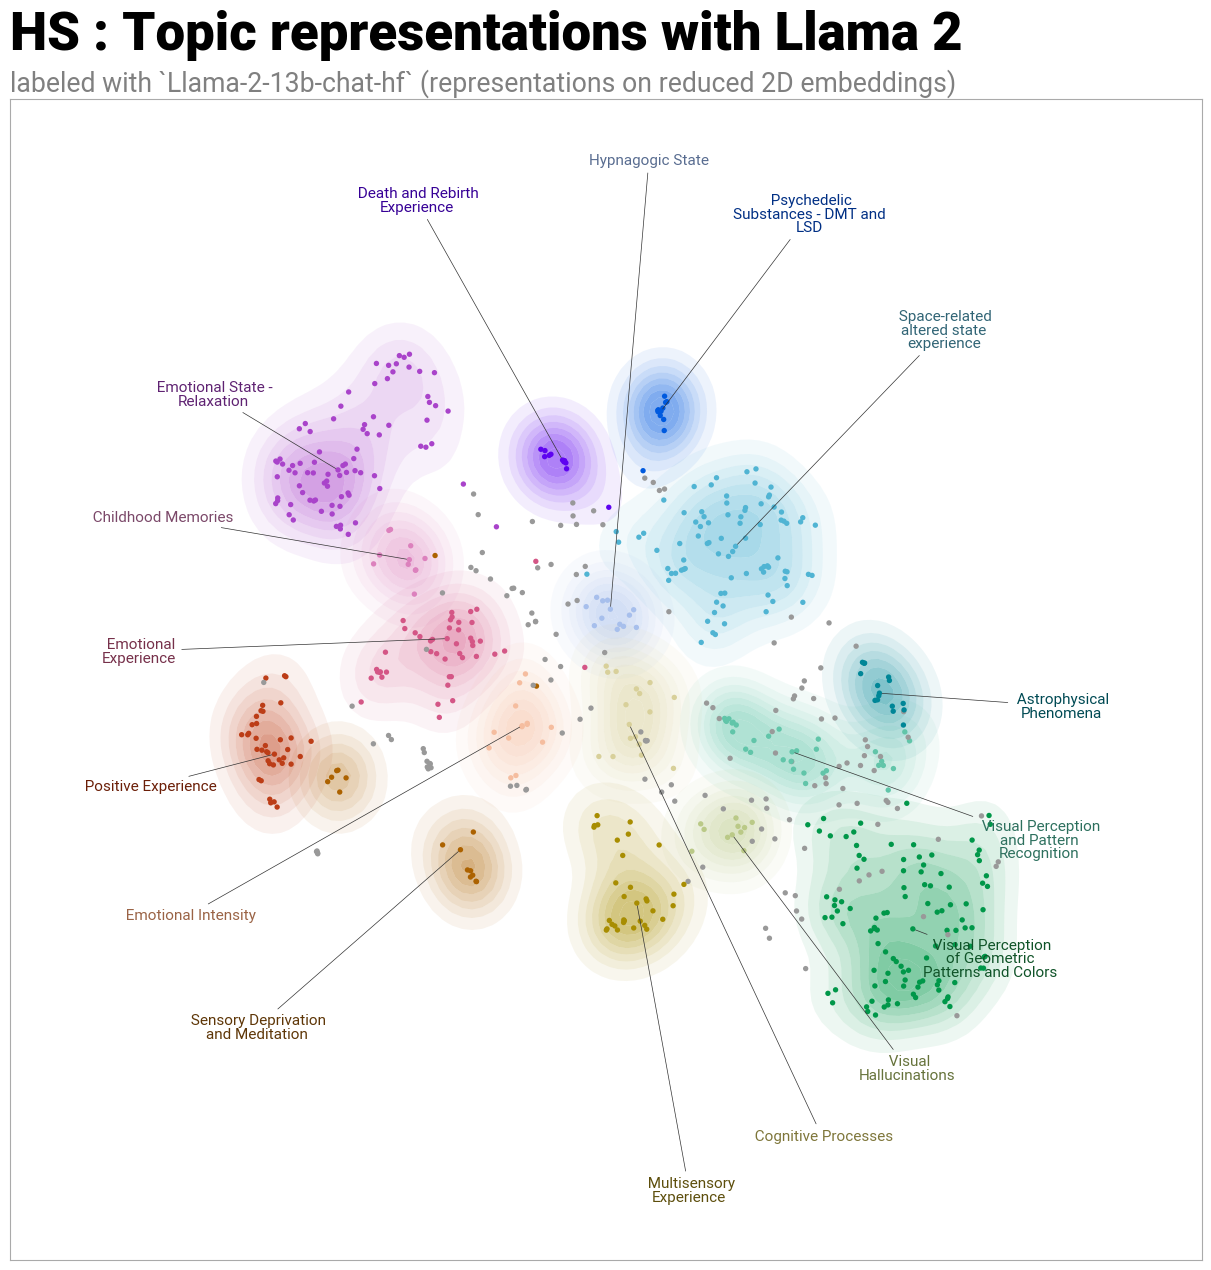

In [25]:
import datamapplot
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=11,
   title=f"{condition} : Topic representations with Llama 2",
   sub_title="labeled with `Llama-2-13b-chat-hf` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);

# Zero-shot TM

In [26]:
sentence_transformer_model = "all-mpnet-base-v2" #"paraphrase-MiniLM-L6-v2"# #"BAAI/bge-small-en" "all-MiniLM-L6-v2'"
embedding_model = SentenceTransformer(sentence_transformer_model)
embeddings = embedding_model.encode(df_reports2, show_progress_bar=True)
print(embedding_model)

vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words=list(stopwords.words('english')))#+list(reduced_custom_stopwords)) #ngram_range=(1,2) : unigrams and bigrams

n_neighbors = chosen_params['n_neighbors']
n_components = chosen_params['n_components']
min_dist = chosen_params['min_dist']
min_cluster_size = int(chosen_params['min_cluster_size'])
min_samples= int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
top_n_words = 10
nr_topics = None


metric='cosine'

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [17]:
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# !wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
--2024-08-07 09:53:22--  https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 52.84.90.106, 52.84.90.33, 52.84.90.129, ...
Connecting to huggingface.co (huggingface.co)|52.84.90.106|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/0e/2d/0e2d501c4480779936b52d3c1b7ca03a7da8fc6d121b0a1612099ee6100c0566/59877734fb4a22e81130b5d9b5155fbabdd5e338bba6a27391c93e77bd672004?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27zephyr-7b-alpha.Q4_K_M.gguf%3B+filename%3D%22zephyr-7b-alpha.Q4_K_M.gguf%22%3B&Expires=1723280002&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMzI4MDAwMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8wZS8yZC8wZTJkNTAxYzQ0ODA3Nzk5MzZiNTJkM2

In [27]:
zeroshot_topic_list = llama2_labels
print(zeroshot_topic_list)

[' SENSORY EXPERIENCE', ' Visual Perception of Geometric Patterns and Colors', ' Emotional State - Relaxation', ' Space-related altered state experience', ' Emotional Experience', ' Positive Experience', ' Multisensory Experience', ' Visual Perception and Pattern Recognition', ' Cognitive Processes', ' Sensory Deprivation and Meditation', ' Astrophysical Phenomena', ' Emotional Intensity', 'Hypnagogic State', ' Psychedelic Substances - DMT and LSD', ' Childhood Memories', ' Death and Rebirth Experience', ' Visual Hallucinations']


In [31]:
# We fit our model using the zero-shot topics
# and we define a minimum similarity. For each document,
# if the similarity does not exceed that value, it will be used
# for clustering instead.
topic_model = BERTopic(
    embedding_model="thenlper/gte-small",
    min_topic_size=10,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.9,#how strict to assign topics to certain docs
    representation_model=representation_model,
    vectorizer_model=vectorizer_model,
    nr_topics=nr_topics
)
topics, probs = topic_model.fit_transform(df_reports2)

topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Llama2,MMR,Representative_Docs
0,-1,79,-1_like_felt_experience_felt like,"[like, felt, experience, felt like, dream, blu...","[felt like, dreaming, like dreaming, memories,...","[\nLabel: Dissociative Experience, , , , , , ,...","[like, felt, experience, felt like, dream, blu...","[I had various flashing images of my memories,..."
1,0,26,0_space_felt_like_ocean,"[space, felt, like, ocean, felt like, one, als...","[ocean feeling, ocean felt, ocean, ocean sense...","[\nDissociative Experience, , , , , , , , , ]","[space, felt, like, ocean, felt like, one, als...","[It felt like I was deep in the ocean., some t..."
2,1,23,1_everything_love_saw_room,"[everything, love, saw, room, felt, connected,...","[saw everything, sense love, thoughts connecti...","[\nLabel: Multiverse and Consciousness, , , , ...","[everything, love, saw, room, felt, connected,...",[I had a vision of string theory - that everyt...
3,2,21,2_colours_eyes_colour_closed,"[colours, eyes, colour, closed, lights, differ...","[closed eyes, opened eyes, eyes shut, eyes ope...",[\nLabel: Visual Perception and Color Phenomen...,"[colours, eyes, colour, closed, lights, differ...",[The colours behind my closed eyes swapped to ...
4,3,18,3_peace_calm_relaxed_peaceful,"[peace, calm, relaxed, peaceful, relaxed peace...","[peacefulness calm, relaxed peaceful, calm rel...","[\nLabel: ""Relaxation and Peacefulness"", , , ,...","[peace, calm, relaxed, peaceful, relaxed peace...",[i love all of it the feeling was amazing and ...
5,4,15,4_music_pace_music became_space,"[music, pace, music became, space, journey, to...","[music took, music progressed, music became, m...","[\nLabel: Auditory-Induced Imagery, , , , , , ...","[music, pace, music became, space, journey, to...",[I tried to really focus on the listening and ...


# LLAMA 3

In [ ]:
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# # !wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf

# # DataMapPlot
# !git clone https://github.com/TutteInstitute/datamapplot.git
# !pip install datamapplot/.

In [ ]:
# # GPU-accelerated HDBSCAN + UMAP
# !pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
# !pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

In [37]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper
# from cuml.manifold import UMAP  # For UMAP dimensionality reduction
# from cuml.cluster import HDBSCAN  # For clustering with HDBSCAN
from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import datamapplot  # For data visualization
import re  # For regular expressions

In [38]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename, cache_dir=path)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)

In [39]:
prompt = """Q:
I have a topic that contains the following documents:
[DOCUMENTS]


The topic is described by the following keywords: '[KEYWORDS]'.


Based on the information about the topic above, please create a short, concise label for this topic, that is very comprehensive for all the sentences that are contained in this topic. Make sure you to only return the label and nothing more.Do not include any extra sentences or explanations.
A:
"""


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


In [49]:
topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  vectorizer_model=vectorizer_model,

  # Hyperparameters
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)




# Show topics
topic_model.get_topic_info()

100%|██████████| 14/14 [00:41<00:00,  2.99s/it]


,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,194,-1_like_saw_felt_body,"[like, saw, felt, body, seeing, thought, feeli...","[intro, felt, visuals, lost, made feel, aspect...","[""Personal Experience with an Event or Activit...",[I thought the fluffy speech and over written ...
1,0,92,0_colors_shapes_patterns_saw,"[colors, shapes, patterns, saw, geometric, lik...","[colors shapes, geometric patterns, colors pat...",[Vivid Geometric Patterns with Colorful Shapes...,"[geometric patterns in 2 colors mainly, someti..."
2,1,86,1_peace_calm_sense_joy,"[peace, calm, sense, joy, relaxation, journey,...","[calm peace, peaceful feeling, peacefulness, p...","[""Sense of inner peace and tranquility""\nThis ...",[an incredible sensory experience with a huge ...
3,2,80,2_felt_like_space_felt like,"[felt, like, space, felt like, flying, traveli...","[universe felt, felt body, like flying, time f...","[""Out-of-body cosmic journey through space and...",[I felt like I was on a journey through space ...
4,3,62,3_felt_experience_feel_relaxed,"[felt, experience, feel, relaxed, peaceful, fe...","[felt relaxed, overwhelming felt, felt euphori...","[""Sense of freedom, comfort, and euphoria""\n--...",[it was comforting and whilst I felt small and...
5,4,53,4_saw_light_vision_eyes,"[saw, light, vision, eyes, like, front, stars,...","[flashing lights, saw stars, vision sometimes,...",[Visions of pulsating lights and patterns affe...,[At first it was unsettling because there were...
6,5,39,5_experience_overall_good_interesting,"[experience, overall, good, interesting, amazi...","[amazing experience, awesome experience, wonde...",[Amazing Experience with High Expectations Met...,"[lovely experience overall, lovely experience ..."
7,6,23,6_music_sound_seemed_music music,"[music, sound, seemed, music music, enjoyed, c...","[music seemed, music, music music, music inten...","[""Sensory Experience of Music and Symbolism"", ...","[I became the music and the music became me, a..."
8,7,17,7_aware_thought_started_thinking,"[aware, thought, started, thinking, found, min...","[momentary visions, overwhelming brain, mindfu...","[""Exploration of Mind and Thoughts During Medi...",[I was aware when I started to follow my train...
9,8,11,8_drugs_acid_lsd_dmt,"[drugs, acid, lsd, dmt, closest, like acid, ps...","[psychedelics, psychedelic trial, psychedelic,...","[""Personal psychedelic experiences, potential ...",[Also possibilities for recreational use\nPerh...


In [50]:
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics

filtered_labels

['Sense of inner peace and tranquility',
 'Exploration of Mind and Thoughts During Meditation',
 'Death and Dying Experience Imagery and Reflections',
 'Amazing Experience with High Expectations Met',
 'Exploration of Mind and Thoughts During Meditation',
 'Sense of inner peace and tranquility',
 'Vivid Geometric Patterns with Colorful Shapes and Forms ',
 'Death and Dying Experience Imagery and Reflections',
 'Sense of inner peace and tranquility',
 'Out of body cosmic journey through space and time',
 'Sense of inner peace and tranquility',
 'Visions of pulsating lights and patterns affecting visual perception ',
 'Exploration of Mind and Thoughts During Meditation',
 'Amazing Experience with High Expectations Met',
 'Personal psychedelic experiences potential uses and effects of DMT and LSD',
 'Personal psychedelic experiences potential uses and effects of DMT and LSD',
 'Vivid Geometric Patterns with Colorful Shapes and Forms ',
 'Sense of freedom comfort and euphoria',
 'Visions o

In [52]:
# Run the visualization
datamapplot.create_plot(
   embeddings,
   all_labels,
   label_font_size=11,
   title=f"{condition_check} : Topic representations with Llama 3",
   sub_title="labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);